# Dpi Setting

In [1]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100 # 300

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from package_sampling.sampling import up_tille, up_brewer, up_systematic, up_max_entropy
from package_sampling.utils import inclusion_probabilities


In [4]:
import os

print(os.getcwd())

/home/divar/projects/graphical-sampling/Simulations


In [5]:
import os
os.chdir('/home/divar/projects/graphical-sampling')

### Dependencies

### Python

In [6]:
# !pip install -q git+https://github.com/mehdimhb/geometric-sampling@dev
# !pip install git+https://github.com/mehdimhb/geometric-sampling@legacy-measure

In [7]:
!apt-get install -y r-base
#!pip install -q rpy2 tqdm


E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [8]:
from rpy2.robjects.packages import importr

import numpy as np
from rpy2.robjects import numpy2ri, default_converter, globalenv
from rpy2.robjects.conversion import localconverter

/home/divar/projects/graphical-sampling/.venv/lib/python3.12/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "LD_LIBRARY_PATH" redefined by R and overriding existing variable. Current: "/usr/lib/jvm/java-17-openjdk-amd64/lib/server:/usr/lib/jvm/java-17-openjdk-amd64/lib/server:", R: "/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-17-openjdk-amd64/lib/server:/usr/lib/jvm/java-17-openjdk-amd64/lib/server:/usr/lib/jvm/java-17-openjdk-amd64/lib/server:"
  warnings.warn(
/home/divar/projects/graphical-sampling/.venv/lib/python3.12/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "LD_LIBRARY_PATH" redefined by R and overriding existing variable. Current: "/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-17-openjdk-amd64/lib/server:/usr/lib/jvm/java-17-openjdk-amd64/lib/server:/usr/lib/jvm/java-17-openjdk-amd64/lib/server:", R: "/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-17-openjdk-amd64/l

In [9]:
%load_ext rpy2.ipython

### R

In [10]:
%%R

#library(spcosa)
#ibrary(spsurvey)
if(!require(WaveSampling)){
    install.packages("WaveSampling")
    library(WaveSampling)
}
if(!require(sampling)){
    install.packages("sampling")
    library(sampling)
}
if(!require(BalancedSampling)){
    install.packages("BalancedSampling")
    library(BalancedSampling)
}

Loading required package: WaveSampling
Loading required package: Matrix
Loading required package: sampling
Loading required package: BalancedSampling


### Imports

In [11]:
import matplotlib as mpl
import numpy as np
from rpy2.robjects import r, numpy2ri
import rpy2.robjects as ro
from matplotlib import pyplot as plt
from itertools import combinations
from collections import OrderedDict
import pandas as pd
import geometric_sampling as gs
from tqdm import tqdm
from tqdm.contrib import tenumerate
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#numpy2ri.activate()

rng = gs.random.rng()

/home/divar/projects/graphical-sampling/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions

### Functions

In [12]:
autumn_cmap = plt.get_cmap('autumn')
plasma_cmap = plt.get_cmap('plasma')

def get_autumn_colors(n_clusters):
    """Returns n_clusters colors from the autumn colormap."""
    colors = autumn_cmap(np.linspace(0.15, 0.95, n_clusters))
    return colors

def get_plasma_colors(n_clusters):
    """Returns n_clusters colors from the plasma colormap."""
    colors = plasma_cmap(np.linspace(0.15, 0.95, n_clusters))
    return colors

# Example usage:
n = 10  # Number of clusters
n_clusters = n
import matplotlib.pyplot as plt
import numpy as np

def lighten_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(mc.to_rgb(c))
    white = np.array([1, 1, 1])
    return tuple((1 - amount) * c + amount * white)

n_clusters = n
base_colors = plt.cm.plasma(np.linspace(0, 1, n_clusters))
light_colors = [lighten_color(col, 0.5) for col in base_colors]

autumn_colors = get_autumn_colors(n_clusters)
plasma_colors = get_plasma_colors(n_clusters)
plasma_colors = light_colors

In [13]:
def plot_convex_hull(points, ax, color, alpha=0.33, edge_color="gray", line_width=0.6):
    """Plot convex hull safely. Always returns (ax, hull or None)."""
    if len(points) < 3:
        return ax, None
    try:
        hull = ConvexHull(points)
        polygon = Polygon(
            points[hull.vertices],
            closed=True,
            facecolor=color,
            alpha=alpha,
            edgecolor=edge_color,
            lw=line_width,
            zorder=1
        )
        ax.add_patch(polygon)
        return ax, hull
    except QhullError:
        # Can't make hull, skip
        return ax, None


# Simulations

## Methods

In [14]:
def scores(coords, probs, n, N, sample_idx, split_size, density_measure=None):
    assert len(coords) == len(probs) == N
    assert len(sample_idx) == n
    sample_mask = np.zeros(N, dtype=int)
    sample_mask[sample_idx] = 1

    with localconverter(default_converter + numpy2ri.converter):
      globalenv['sample_mask'] = sample_mask
      globalenv['sample_idx'] = sample_idx + 1  # Or int(sample_idx + 1) if it's just one value
      globalenv['coords'] = coords
      globalenv['probs'] = probs
      globalenv['n'] = n
      globalenv['N'] = N
    # ro.globalenv['sample_mask'] = sample_mask
    # ro.globalenv['sample_idx'] = sample_idx + 1
    # ro.globalenv['coords'] = coords
    # ro.globalenv['probs'] = probs
    # ro.globalenv['n'] = n
    # ro.globalenv['N'] = N
    #ro.globalenv['split_size'] = split_size


    r_code = """
W <- wpik(coords,probs)
W <- W - diag(diag(W))
diag(W) <- 0  # Ensure W has zero diagonal


ib_value <- tryCatch({
  IB(W, sample_mask)  # Moran's Index
}, error = function(e) {
  Inf
})

sb_value <- tryCatch({
  sb(probs, coords, sample_idx)  # Spatial balance
}, error = function(e) {
  Inf
})

sblb_value <- tryCatch({
  sblb(probs, coords, sample_idx)  # Spatial balance using local balance
}, error = function(e) {
  Inf
})
"""
    ro.r(r_code)
    IB_value = ro.r("ib_value")[0]
    SB_value = ro.r("sb_value")[0]
    SBLB_value = ro.r("sblb_value")[0]
    if density_measure is None:
      scaled_coords = (coords - np.min(coords, axis=0)) / np.ptp(coords, axis=0)
      density_measure = gs.measure.Density(scaled_coords, probs, n, split_size=0.001)
    # print(sample_idx.reshape(1, -1))
    scores = density_measure.score(sample_idx.reshape(1, -1))
    return scores[0], IB_value, SBLB_value
    # return scores[0][0], SB_value, IB_value, SBLB_value
    # Legacy Measure: return scores[3][0], SB_value, IB_value, SBLB_value

In [15]:
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects import default_converter, numpy2ri
from rpy2.robjects.conversion import localconverter

def local_pivotal_samples(coords, probs, n, num_samples):
    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        with localconverter(default_converter + numpy2ri.converter):
            ro.globalenv['coords'] = coords
            ro.globalenv['probs'] = probs
        r_code = """
s <- lpm(probs, coords) # Local Pivotal Method (BalancedSampling)
"""
        ro.r(r_code)
        with localconverter(default_converter + numpy2ri.converter):
            sample_idx = np.array(list(ro.r("s"))) - 1
        samples_idx[i] = sample_idx

    return samples_idx

def k_means_samples(coords, probs, n, num_samples, n_zones, sort_method):
    # Placeholder, replace with your actual method if necessary
    return gs.sampling.KMeansSpatialSamplingSimple(coords, probs, n=n, n_zones=n_zones, sort_method=sort_method, tolerance=4, split_size=0.001).sample(num_samples)

def random_samples(coords, probs, n, num_samples):
    # Placeholder, replace with your implementation if available
    return gs.sampling.RandomSampling(coords, probs, n=n).sample(num_samples)

def upmaxentropy_samples(probs, num_samples):
    with localconverter(default_converter + numpy2ri.converter):
        ro.globalenv['probs'] = probs
    n = int(round(np.sum(probs)))

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
mask <- UPmaxentropy(probs)
"""
        ro.r(r_code)
        with localconverter(default_converter + numpy2ri.converter):
            mask = np.array(ro.r("mask"))
        if mask.dtype != np.bool_:
            mask = mask.astype(bool)
        sample_idx = np.where(mask)[0]
        samples_idx[i] = sample_idx

    return samples_idx

def wave_samples(coords, probs, n, num_samples):
    with localconverter(default_converter + numpy2ri.converter):
        ro.globalenv['coords'] = coords
        ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
wave_mask <- wave(coords, probs)
"""
        ro.r(r_code)
        with localconverter(default_converter + numpy2ri.converter):
            mask = np.array(ro.r("wave_mask"))
        if mask.dtype != np.bool_:
            mask = mask.astype(bool)
        sample_idx = np.where(mask)[0]
        samples_idx[i] = sample_idx

    return samples_idx

def spcosa_samples(coords, n, num_samples):
    """
    Uses the spcosa R package for equal probability spatially balanced sampling.
    """
    with localconverter(default_converter + numpy2ri.converter):
        ro.globalenv['coords'] = coords
    N = coords.shape[0]
    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = f"""
library(spcosa)
set.seed({np.random.randint(1, 1e8)})
df <- data.frame(x = coords[,1], y = coords[,2])
coordinates(df) <- ~x + y
gridded(df) <- TRUE
stratification <- stratify(df, nStrata = {n}, nTry = 50)
samples <- spsample(stratification)
# Extract row indices in original data
whichrow <- as.integer(rownames(as(samples, "data.frame")))
"""
        ro.r(r_code)
        with localconverter(default_converter + numpy2ri.converter):
            sample_idx = np.array(ro.r("whichrow")) - 1  # zero-based for Python
        samples_idx[i] = sample_idx
    return samples_idx

def find_samples(coords, probs, n, num_samples, ep_mode="auto"):
    """
    Returns a dict of various sampling methods. 
    If ep_mode=="auto", heuristically deduce EP/UP from probs.
    """
    # Determine if this is the EP case: uniform probs and sum ~ n
    result = {
        "K-Means (11_lexico)": k_means_samples(coords, probs, n, num_samples, (1, 1), sort_method="lexico"),
        "K-Means (11_random)": k_means_samples(coords, probs, n, num_samples, (1, 1), sort_method="random"),
        "K-Means (22_lexico)": k_means_samples(coords, probs, n, num_samples, (2, 2), sort_method="lexico"),
        "K-Means (22_random)": k_means_samples(coords, probs, n, num_samples, (2, 2), sort_method="random"),
        "K-Means (33_lexico)": k_means_samples(coords, probs, n, num_samples, (3, 3), sort_method="lexico"),
        "K-Means (33_random)": k_means_samples(coords, probs, n, num_samples, (3, 3), sort_method="random"),
        # "K-Means (23_lexico)": k_means_samples(coords, probs, n, num_samples, (2, 3), sort_method="lexico"),
        # "K-Means (23_random)": k_means_samples(coords, probs, n, num_samples, (2, 3), sort_method="random"),
        "Local Pivotal": local_pivotal_samples(coords, probs, n, num_samples),
        "Random": random_samples(coords, probs, n, num_samples),
        "UPmaxentropy": upmaxentropy_samples(probs, num_samples),
        "Wave": wave_samples(coords, probs, n, num_samples),
    }
    return result

## Swiss

### Plot Swiss Data

In [16]:
import numpy as np
import pandas as pd

n = 10


# --- SEEDING for reproducibility ---
np.random.seed(42)

# --- PARAMS ---
# Target sample size
swiss_csv = '/home/divar/projects/graphical-sampling/Simulations/swiss.csv'

# Load your dataset
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

swiss_df_0 = pd.read_csv(swiss_csv)
coords = swiss_df_0[['COORD_X', 'COORD_Y']].values

# Cluster every row into 'reduced_data_size' clusters
reduced_data_size = 250
kmeans = KMeans(n_clusters=reduced_data_size, random_state=42)
labels = kmeans.fit_predict(coords)

# Find the point in each cluster that is closest to its centroid
closest_idxs = []
for i in range(reduced_data_size):
    cluster_points = np.where(labels == i)[0]
    if len(cluster_points) > 0:  # safe check, should always be true in KMeans
        centroid = kmeans.cluster_centers_[i]
        closest = cluster_points[np.argmin(np.linalg.norm(coords[cluster_points] - centroid, axis=1))]
        closest_idxs.append(closest)

# Now, select the original rows, **maintaining ALL columns**
swiss_df = swiss_df_0.iloc[closest_idxs].copy().reset_index(drop=True)  # don't reset_index!





# --- 1. Setup holders for all coordinates/probs/populations ---
populations = {}
probabilities = {}
pop_objs = {}


# Extract original x/y for clarity
xy = swiss_df[['COORD_X', 'COORD_Y']]
# scaled_xy = (xy - xy.min()) / (xy.max() - xy.min())
scaled_xy = xy
swiss_df[['x', 'y']] = scaled_xy
#meuse_df['x'] = round(meuse_df['x']/10000)
#meuse_df['y'] = round(meuse_df['y']/10000)
coords_swiss = swiss_df[['x', 'y']].to_numpy()
N_swiss = coords_swiss.shape[0]

area = swiss_df['AREA'].clip(1, 100)
# Assumes rng and inclusion_probabilities are defined in your environment
probs_swiss_eq = rng.equal_probabilities(n, N_swiss)
probs_swiss_uneq = inclusion_probabilities(area, n)

populations['swiss'] = coords_swiss
probabilities['swiss_eq'] = probs_swiss_eq
probabilities['swiss_uneq'] = probs_swiss_uneq

# --- 3. Create population objects based on meuse data only ---
hard = gs.sampling.KMeansSpatialSamplingSimple(
    coords_swiss, probs_swiss_eq, n=n, n_zones=(3, 3), tolerance=3, split_size=0.001)
pop_objs['swiss_eq'] = hard.popu

hard = gs.sampling.KMeansSpatialSamplingSimple(
    coords_swiss, probs_swiss_uneq, n=n, n_zones=(4, 4), tolerance=3, split_size=0.001)
pop_objs['swiss_uneq'] = hard.popu



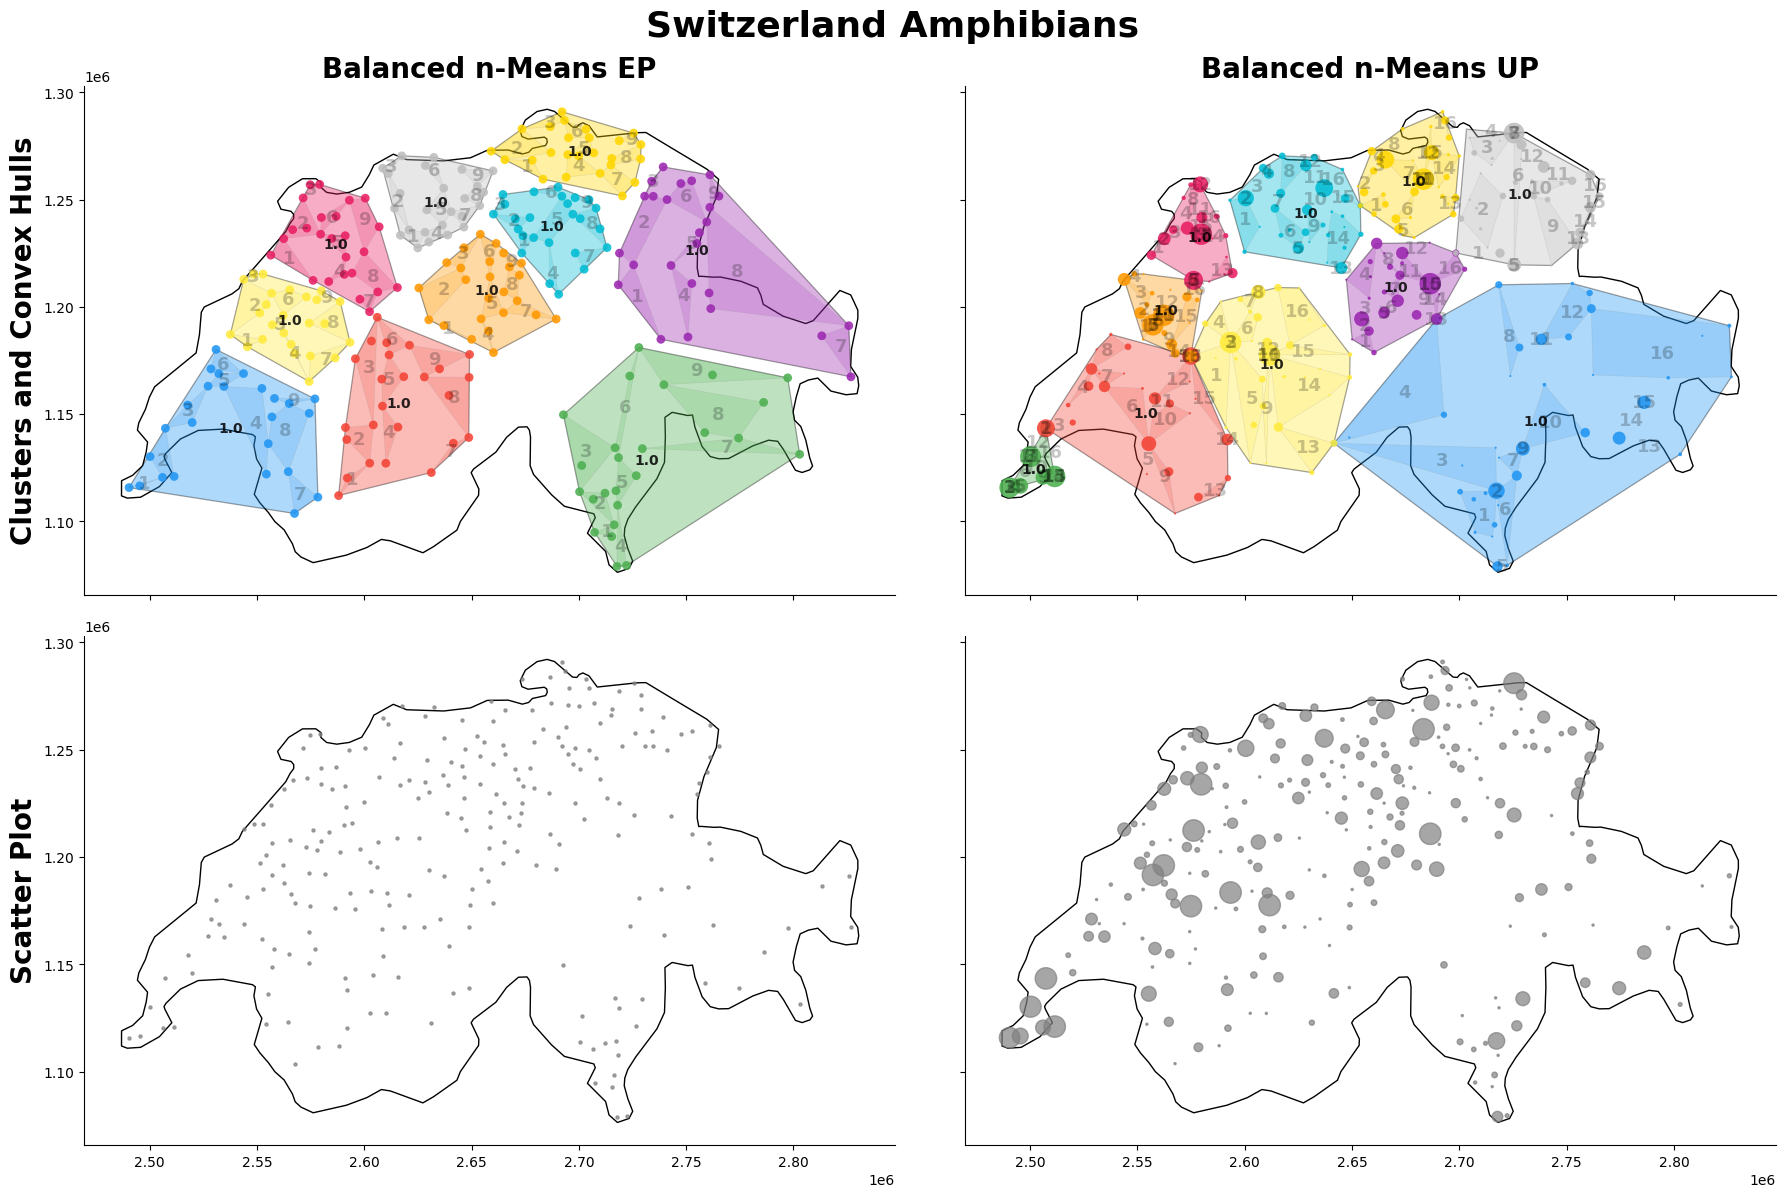

In [17]:
import matplotlib.pyplot as plt
import geopandas as gpd

swiss_shp = '/home/divar/Downloads/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp'

world = gpd.read_file(swiss_shp)
swiss_map = world[world['ADMIN'] == 'Switzerland'].to_crs(epsg=2056)

col_labels = [
    "Balanced n-Means EP",
    "Balanced n-Means UP"
]

fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharex=True, sharey=True)

for col, key in enumerate(['swiss_eq', 'swiss_uneq']):
    ax = axes[1, col]
    swiss_map.plot(ax=ax, color="white", edgecolor="black", linewidth=1.0, zorder=0)
    pops = pop_objs[key]
    coords = pops.coords
    probs = pops.probs

    if key == 'swiss_eq':
        # Uniform size
        s = 5
        ax.scatter(coords[:, 0], coords[:, 1], c="gray", s=s, alpha=0.7, zorder=2)
    else:  # 'swiss_uneq'
        # Size proportional to probs, clipped for visibility
        s = probs * 1000  # You can adjust scale/clipping as needed
        ax.scatter(coords[:, 0], coords[:, 1], c="gray", s=s, alpha=0.7, zorder=2)

    
    # ----------- BOTTOM ROW: clusters/hull plot -----------
    ax = axes[0, col]
    
    swiss_map.plot(ax=ax, color="white", edgecolor="black", linewidth=1.0, zorder=0)
    pops.plot(ax=ax)
    ax.set_title("", fontsize=14, fontweight='bold')
    ax.set_aspect("equal")
    if col == 0:
        ax.set_ylabel("Clusters and Convex Hulls", fontsize=20, fontweight='bold')
    ax.set_title(col_labels[col], fontsize=20, fontweight='bold')
    ax.set_aspect("equal")

# Only show left and bottom spines
for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[1,0].set_ylabel("Scatter Plot", fontsize=20, fontweight='bold')
plt.tight_layout(rect=[0, 0.01, 1, 0.96])
plt.subplots_adjust(wspace=0.08, hspace=0.08)
plt.suptitle("Switzerland Amphibians", fontsize=26, fontweight='bold', y=0.995)
plt.show()

### Swiss Simulation

In [18]:
import numpy as np
import pandas as pd



# --- SEEDING for reproducibility ---
np.random.seed(42)


# --- 1. Setup holders for all coordinates/probs/populations ---
populations = {}
probabilities = {}
pop_objs = {}


# Extract original x/y for clarity
xy = swiss_df[['COORD_X', 'COORD_Y']]
scaled_xy = (xy - xy.min()) / (xy.max() - xy.min())
swiss_df[['x', 'y']] = scaled_xy
#meuse_df['x'] = round(meuse_df['x']/10000)
#meuse_df['y'] = round(meuse_df['y']/10000)
coords_swiss = swiss_df[['x', 'y']].to_numpy()
N_swiss = coords_swiss.shape[0]
print(N_swiss)
area = swiss_df['AREA'].clip(1, 150)
# Assumes rng and inclusion_probabilities are defined in your environment
probs_swiss_eq = rng.equal_probabilities(n, N_swiss)
probs_swiss_uneq = inclusion_probabilities(area, n)

populations['swiss'] = coords_swiss
probabilities['swiss_eq'] = probs_swiss_eq
probabilities['swiss_uneq'] = probs_swiss_uneq

# --- 3. Create population objects based on meuse data only ---
hard = gs.sampling.KMeansSpatialSamplingSimple(
    coords_swiss, probs_swiss_eq, n=n, n_zones=(2, 2), tolerance=3, split_size=0.001)
pop_objs['swiss_eq'] = hard.popu

hard = gs.sampling.KMeansSpatialSamplingSimple(
    coords_swiss, probs_swiss_uneq, n=n, n_zones=(2, 2), tolerance=3, split_size=0.001)
pop_objs['swiss_uneq'] = hard.popu



250


In [19]:
import pandas as pd
import os

folder = "data_samples/coords_probs"
os.makedirs(folder, exist_ok=True)

# Save each population's coordinates and probabilities, including "n" in the filename
for name, pop in pop_objs.items():
    df = pd.DataFrame(pop.coords, columns=["x", "y"])
    df["prob"] = pop.probs
    filename = f"{name}_n={n}.csv"    # Appends the value of n to the filename
    df.to_csv(os.path.join(folder, filename), index=False)
    print(f"Saved {filename}")

Saved swiss_eq_n=10.csv
Saved swiss_uneq_n=10.csv


#### Swiss sampling

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
folder = "data_samples/results"
os.makedirs(folder, exist_ok=True)
all_coords = []
all_probs = []
names = [
    f"swiss_uneq_n={n}",
    f"swiss_eq_n={n}"
]
for name in names:
    df = pd.read_csv(f"data_samples/coords_probs/{name}.csv")
    coords = df[["x", "y"]].values
    probs = df["prob"].values
    all_coords.append(coords)
    all_probs.append(probs)
print(sum(probs))
print(len(probs))
sample_cnt = 1000
columns = ["Method", "Density", "Moran", "Local Balance"]

for coords, probs, name in zip(all_coords, all_probs, names):
    print(name)
    n = int(np.round(np.sum(probs)))
    N =len(probs)
    # Any code for one set, put here:
    sample_methods = find_samples(coords, probs, n, sample_cnt)
    scaled_coords = (coords - np.min(coords, axis=0)) / np.ptp(coords, axis=0)
    density_measure = gs.measure.Density(scaled_coords, probs, n, split_size=0.001)
    rows = np.array([
    [method, *scores(coords, probs, n, N, s, density_measure)]
    for method, samples in sample_methods.items()
    if samples is not None  # <----- add this
    for s in tqdm(samples, total=sample_cnt)
])
    df = pd.DataFrame(rows, columns=columns)
    df = df.astype({
        "Density": float,
        "Moran": float,
        "Local Balance": float
    })
    filename = os.path.join(folder, f"initial_results_{name}.csv")
    df.to_csv(filename, index=False)
    print(f"Saved: {filename}")

9.999999999999963
250
swiss_uneq_n=10


 74%|███████▎  | 736/1000 [1:33:36<40:07,  9.12s/it]  

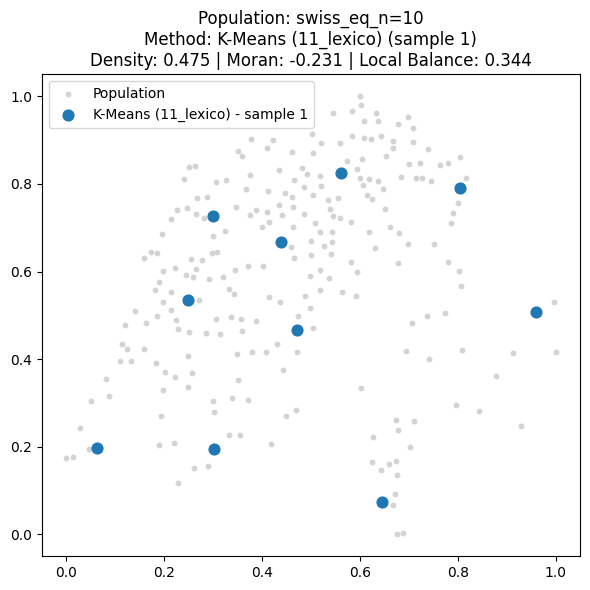

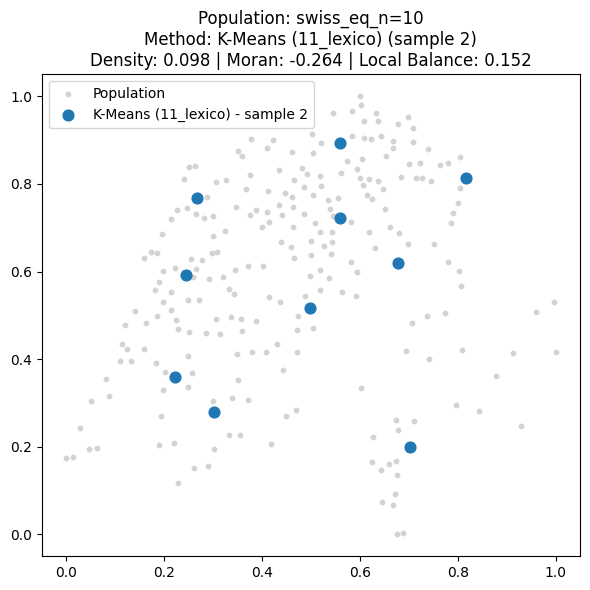

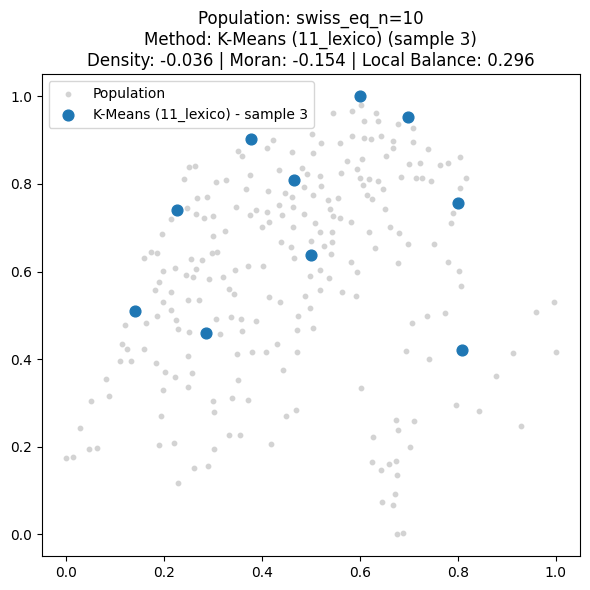

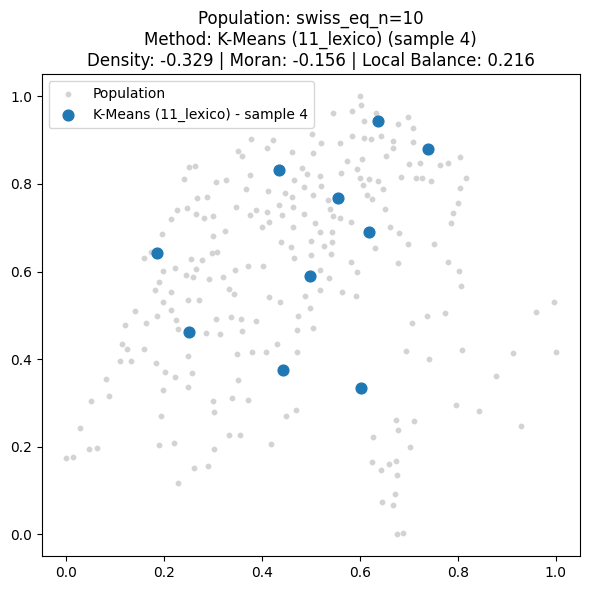

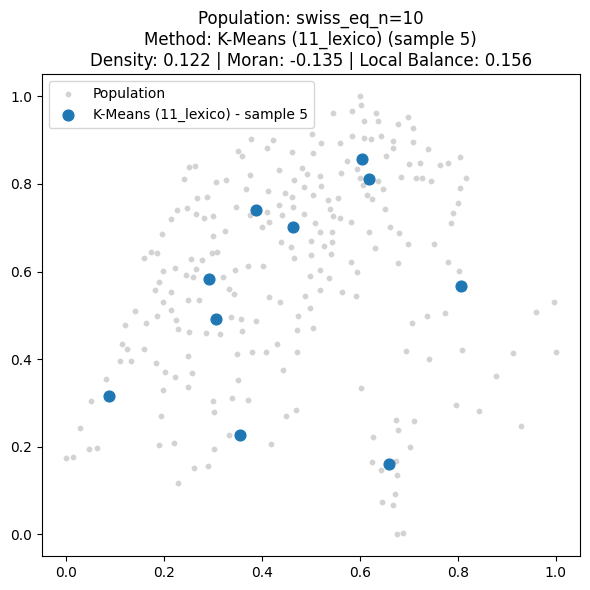

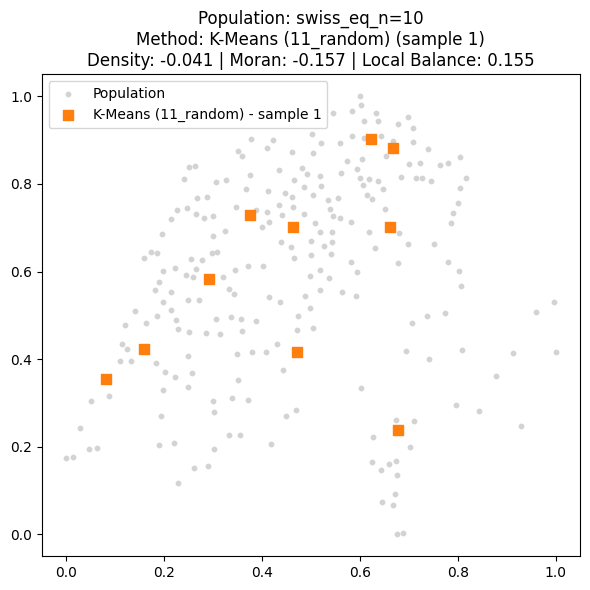

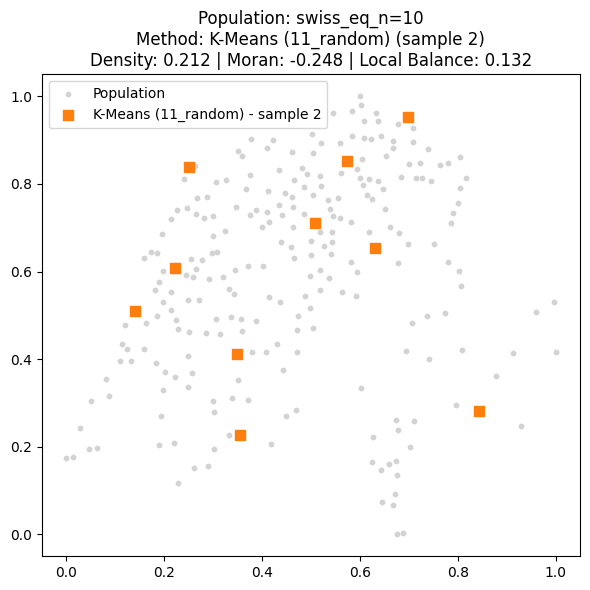

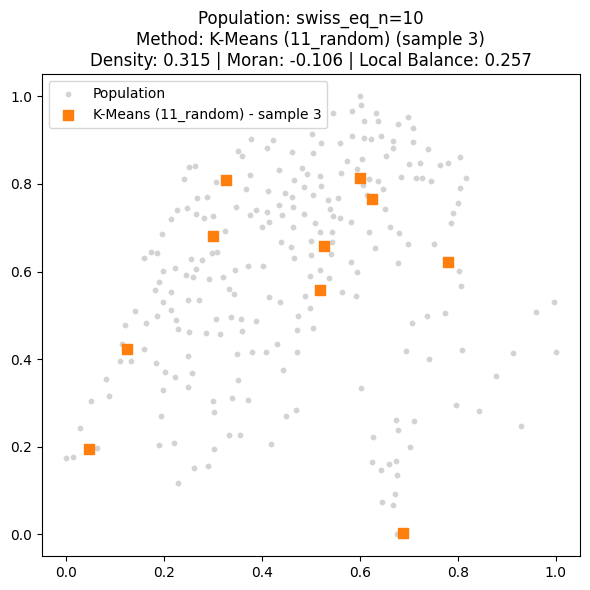

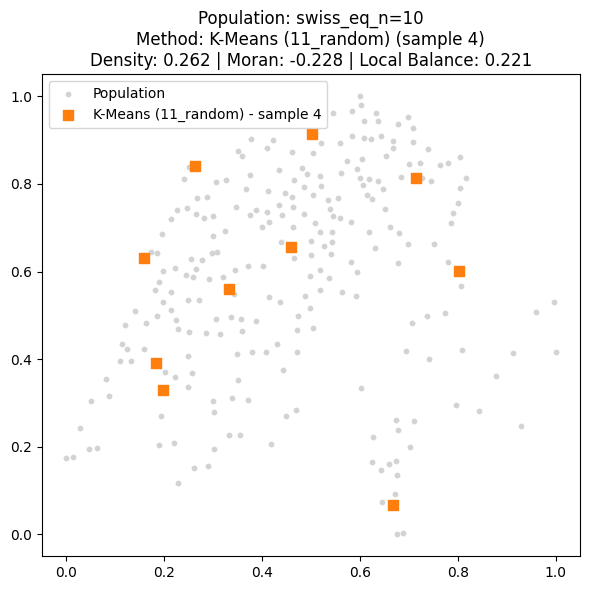

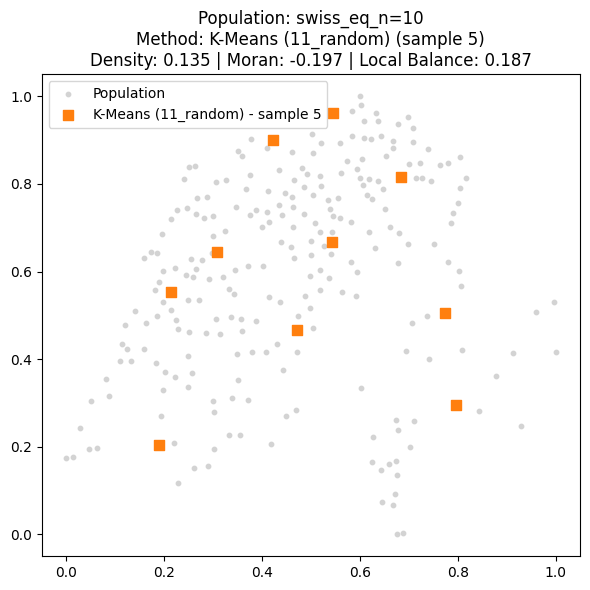

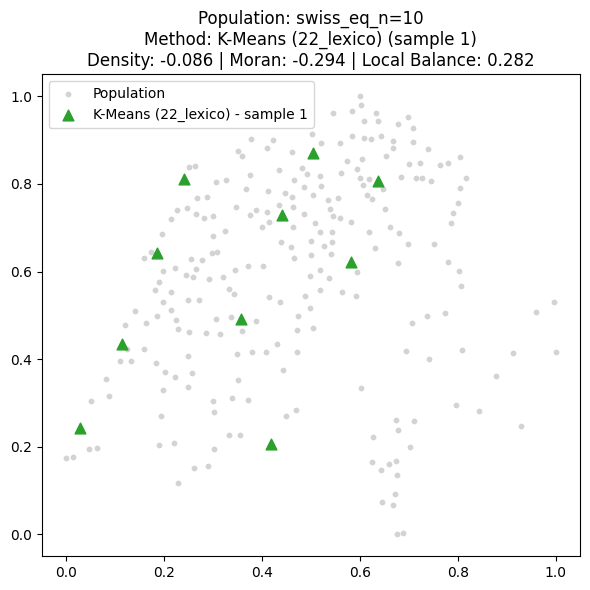

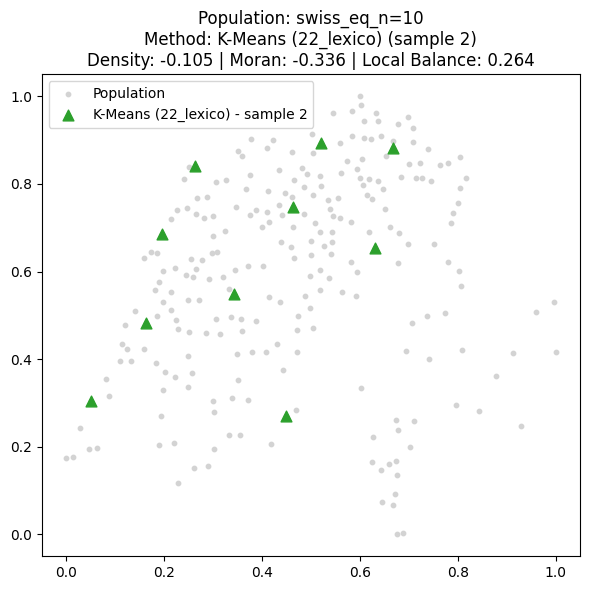

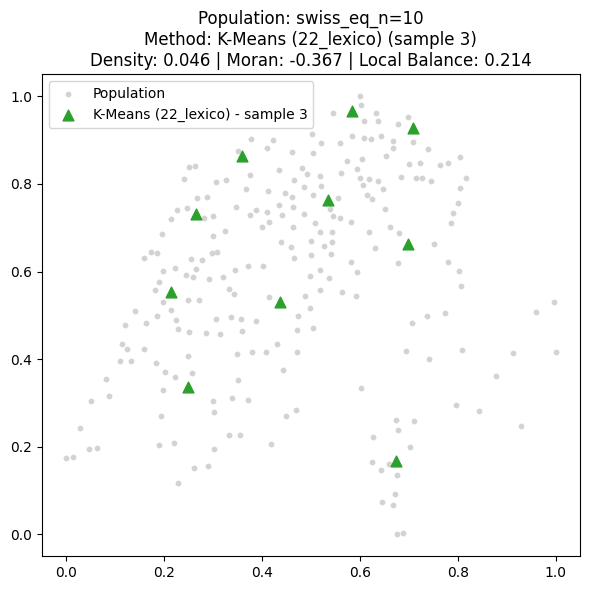

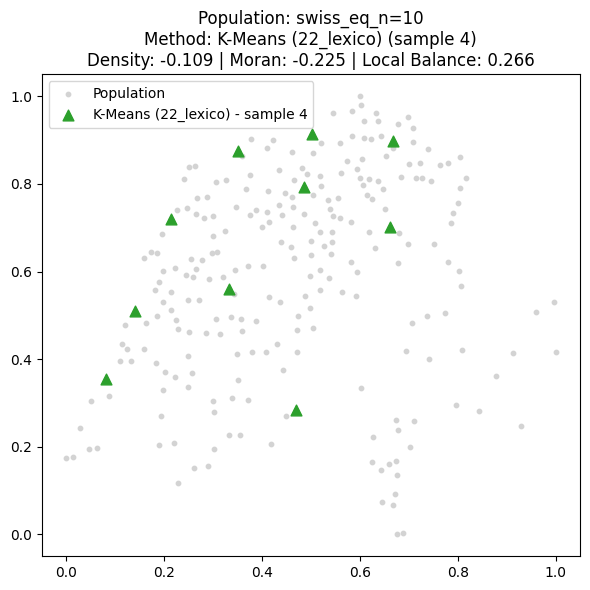

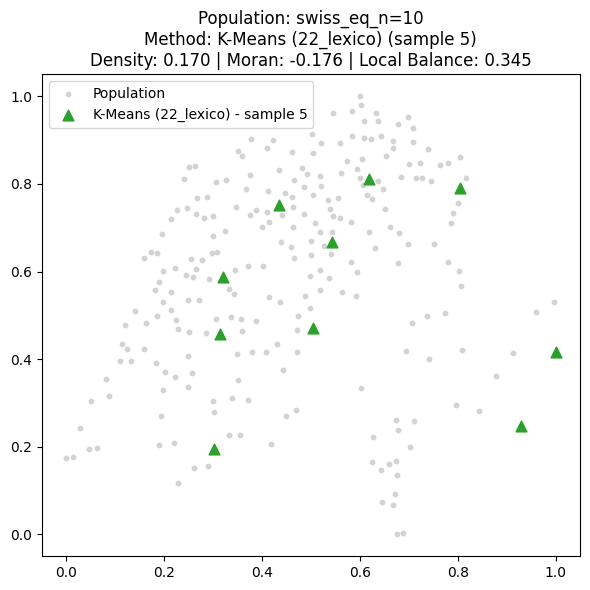

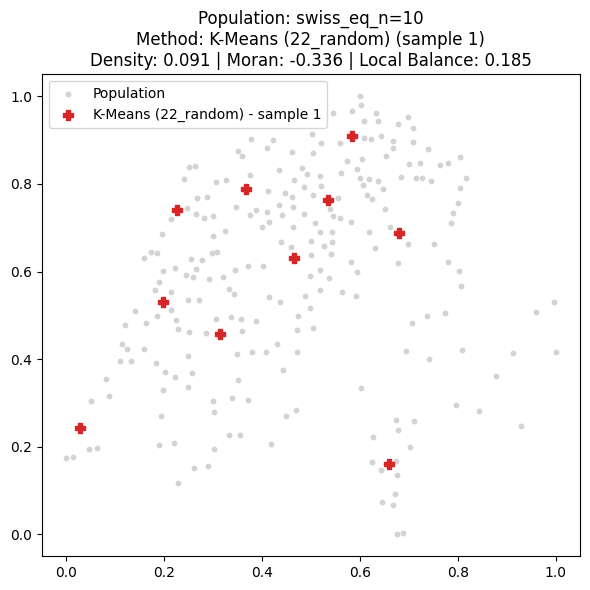

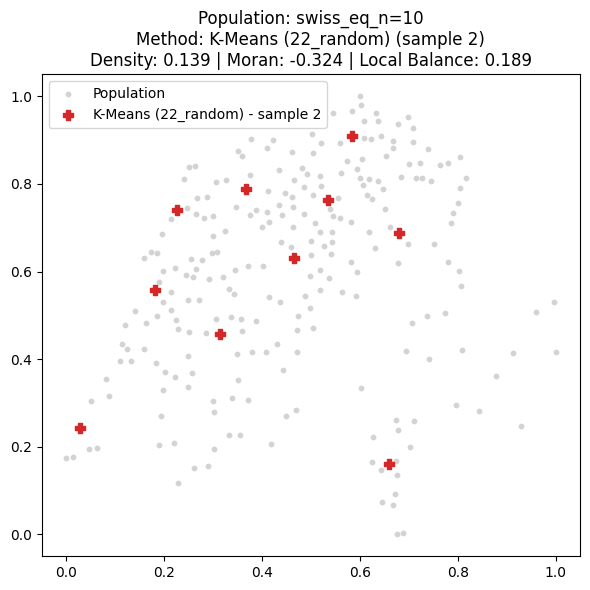

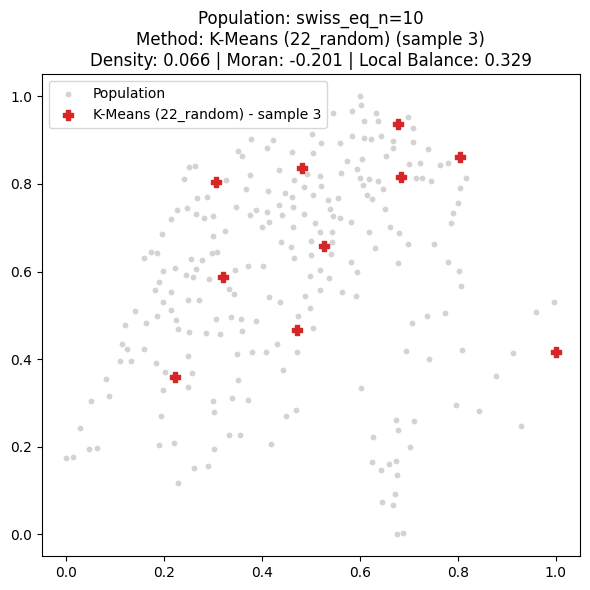

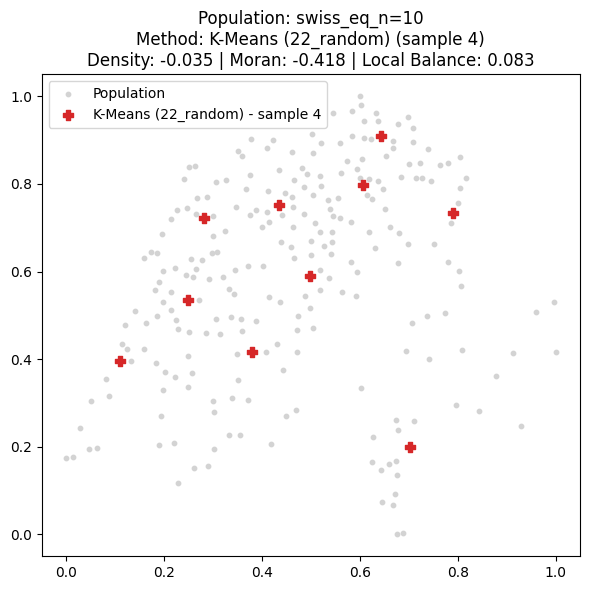

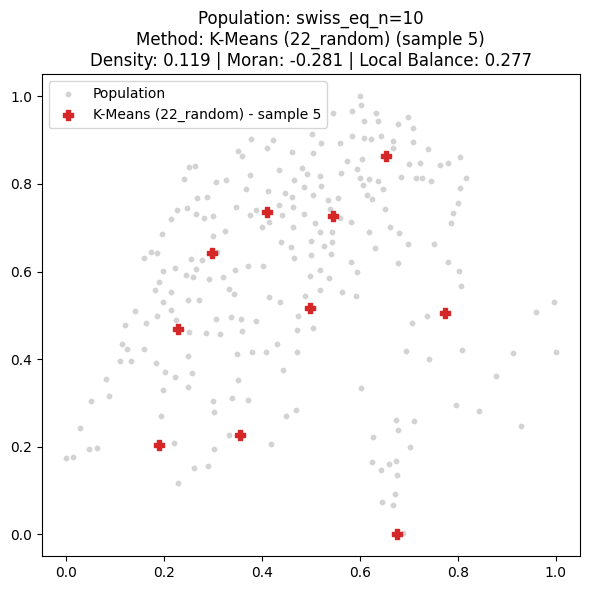

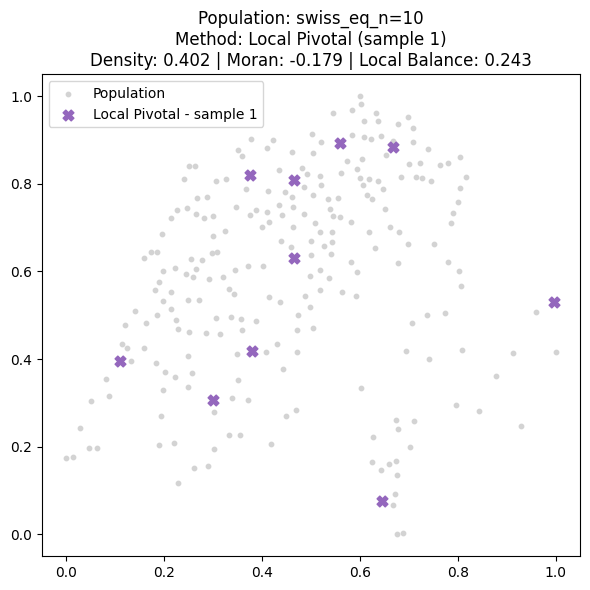

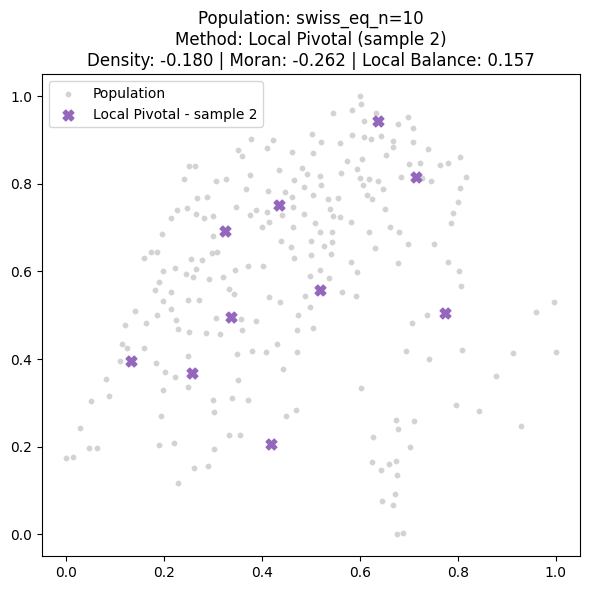

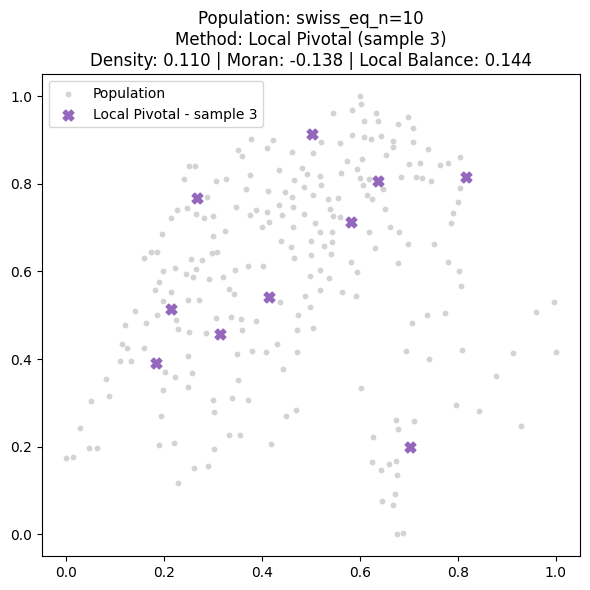

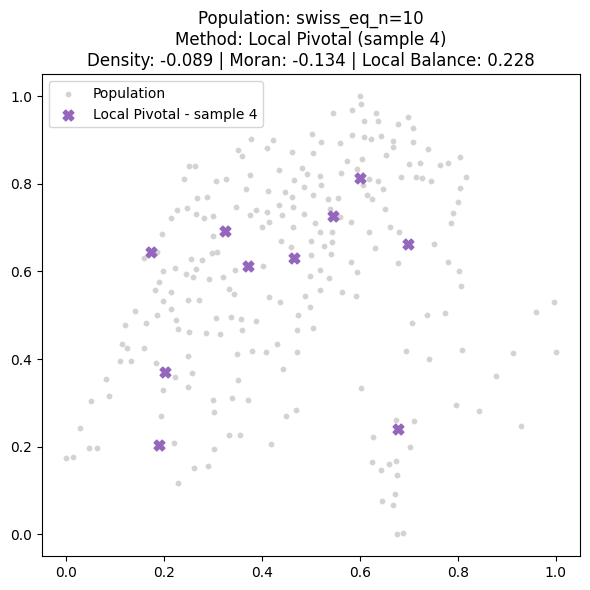

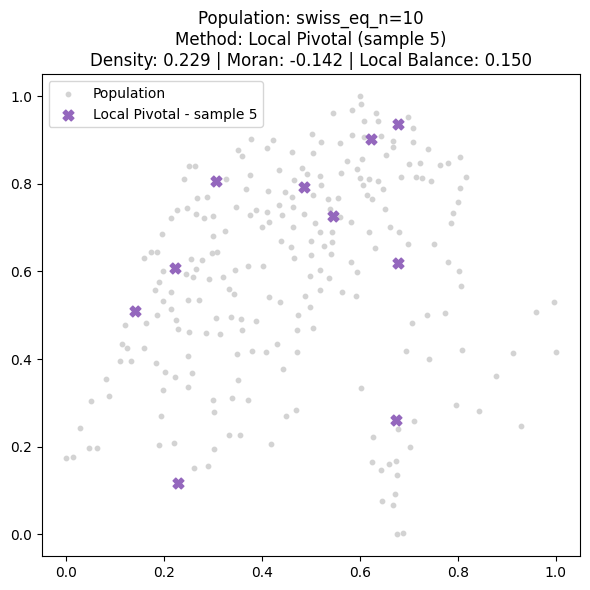

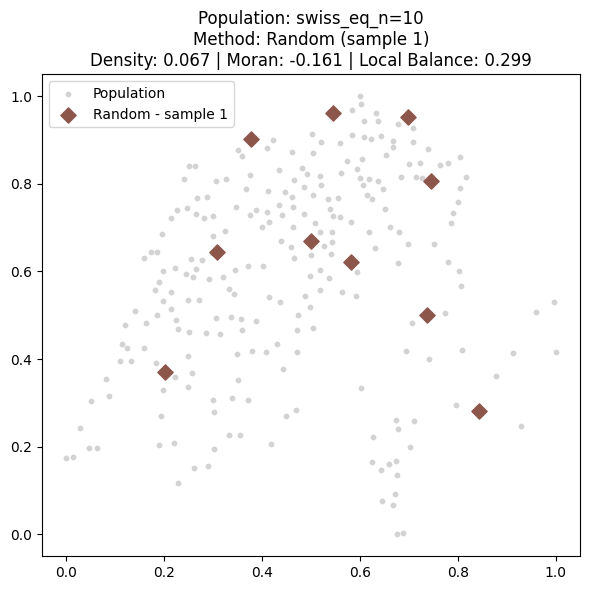

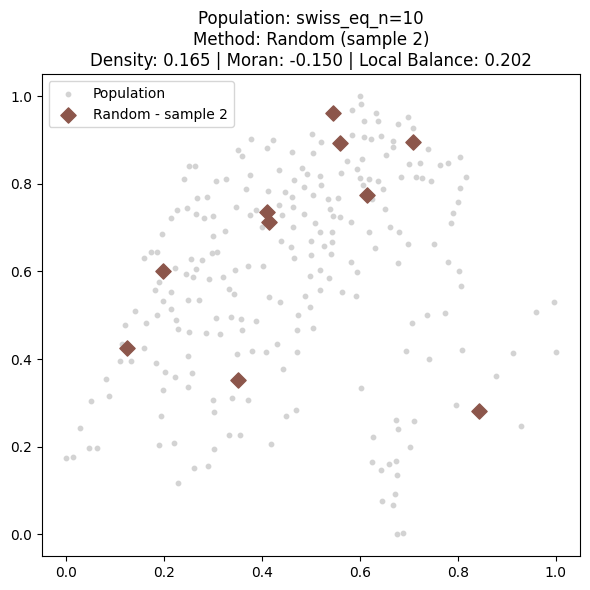

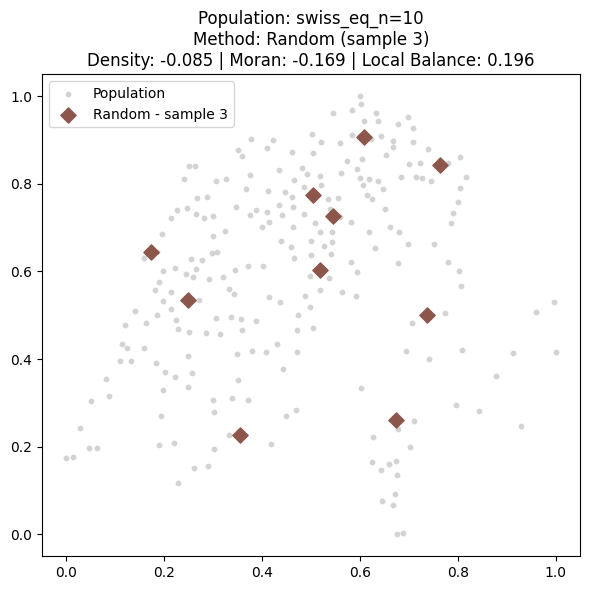

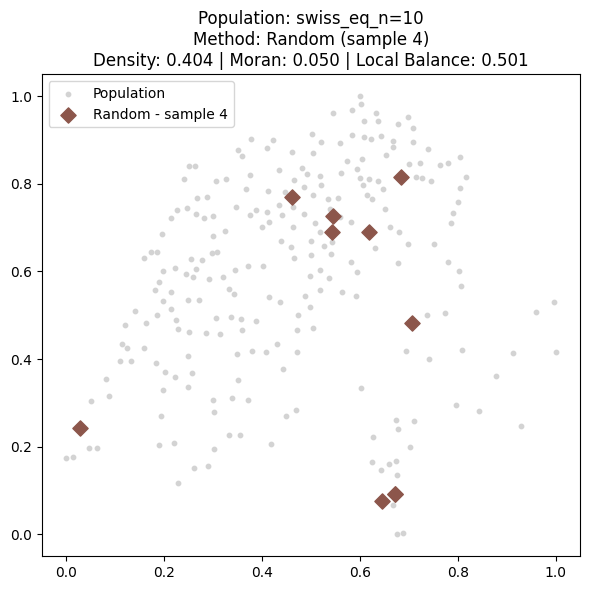

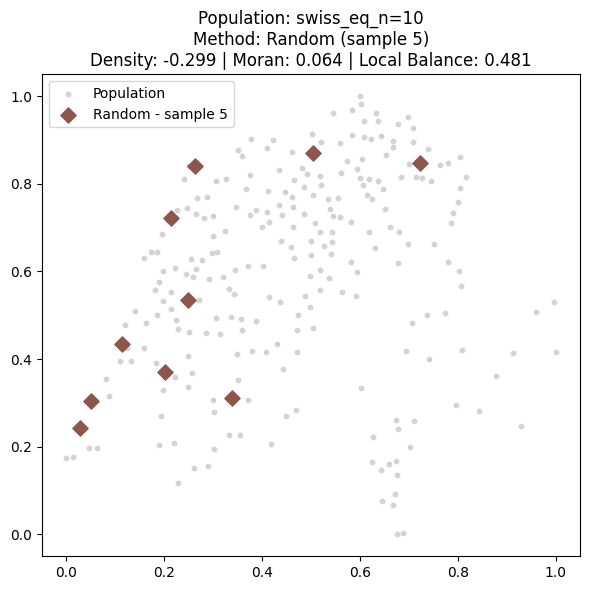

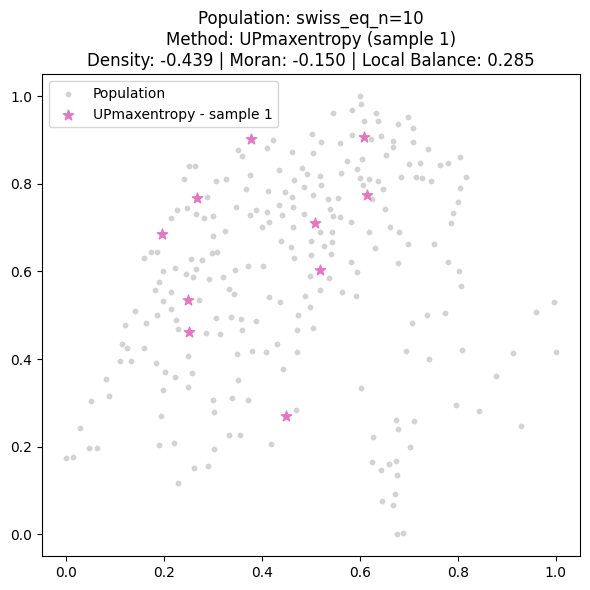

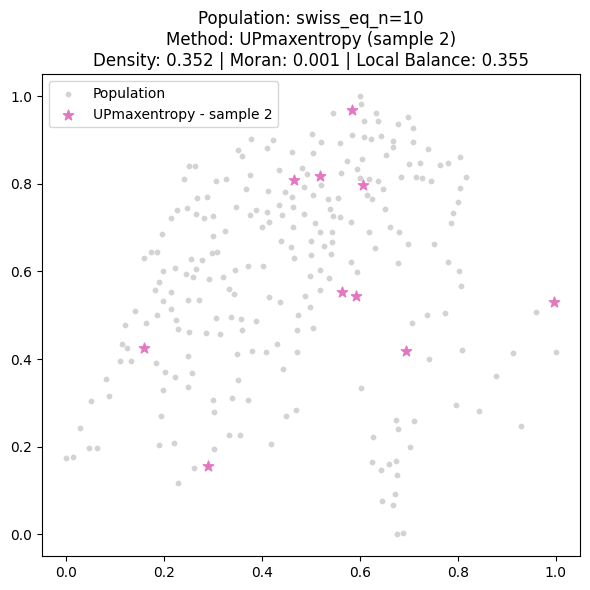

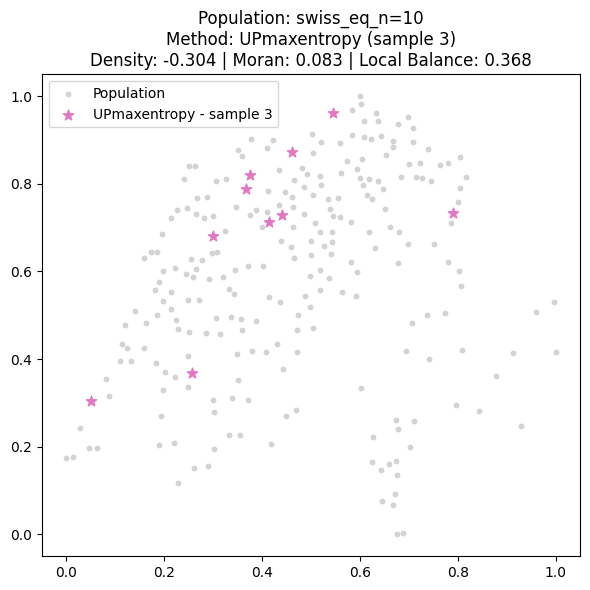

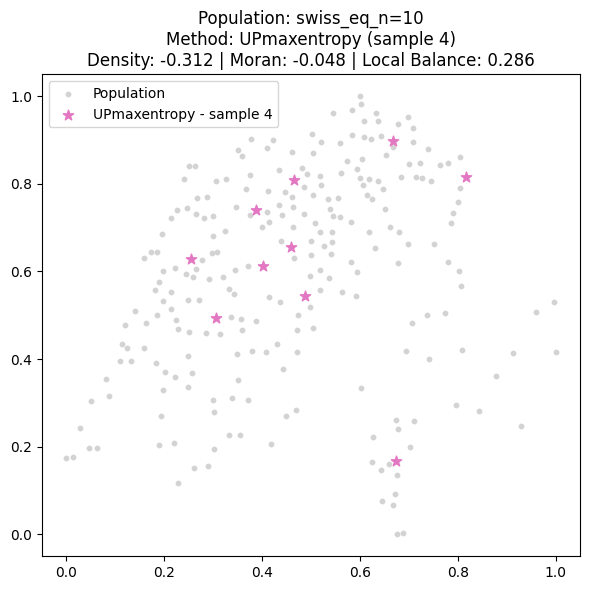

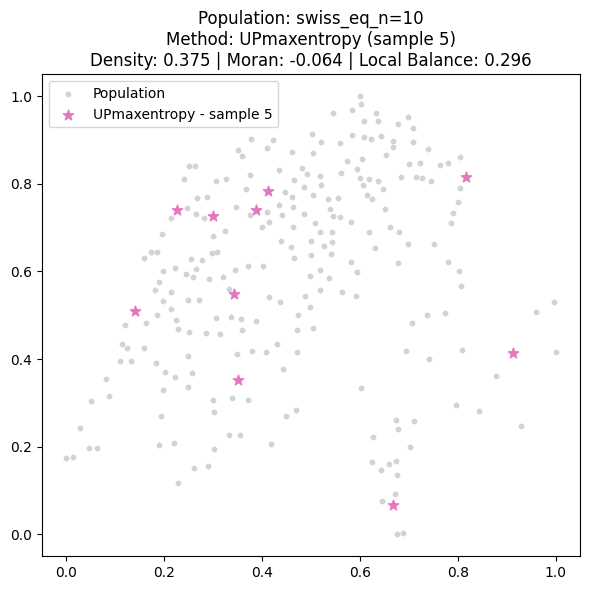

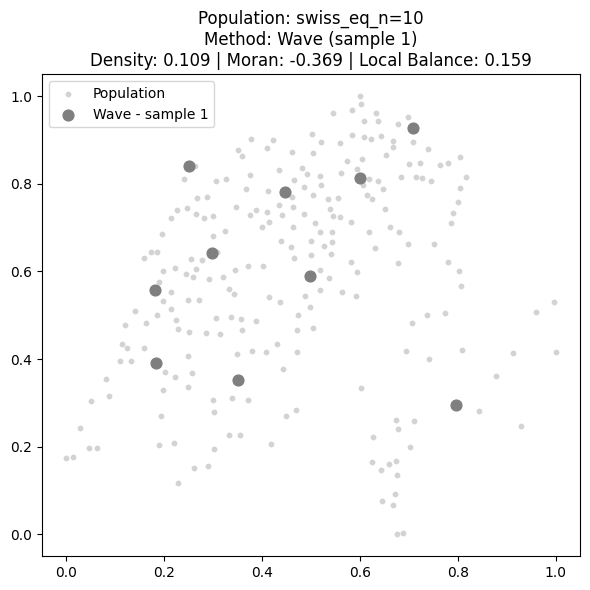

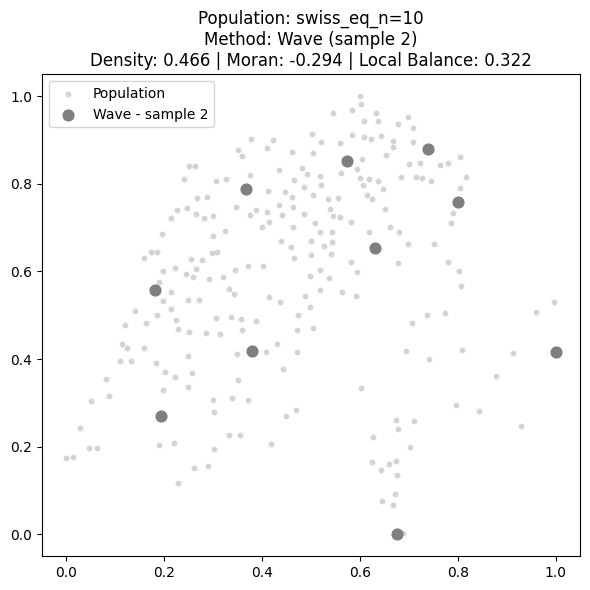

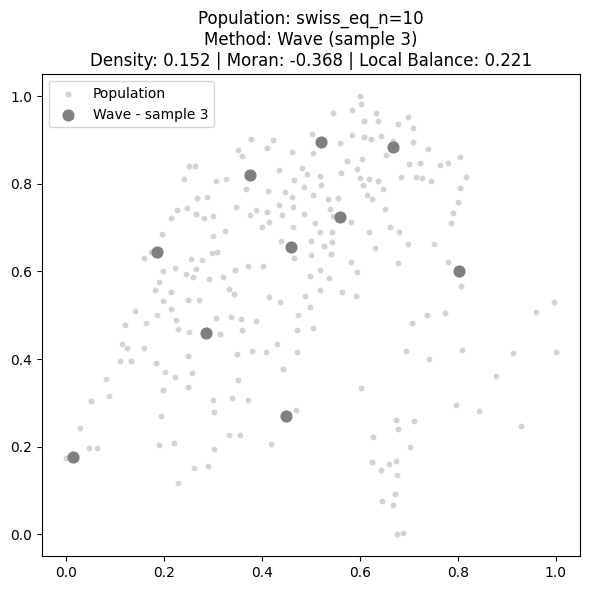

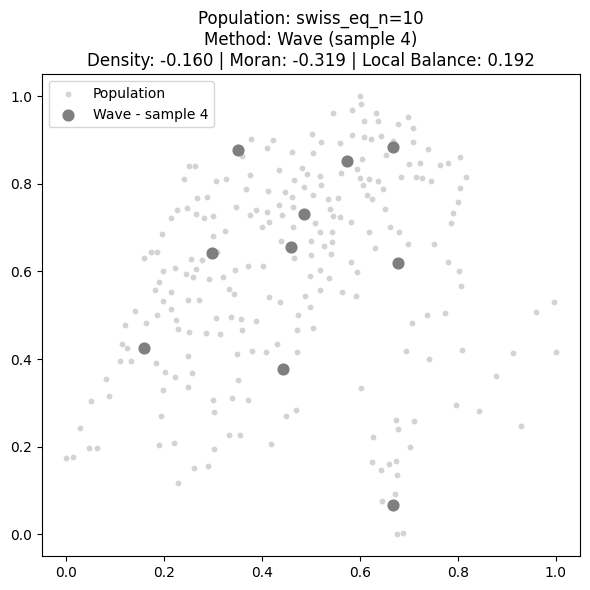

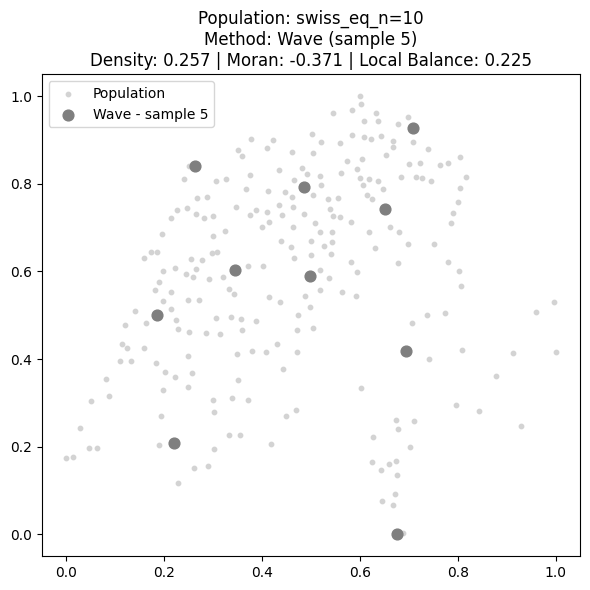

In [ ]:
import matplotlib.pyplot as plt

samples_to_plot = 1 # how many samples per method to plot
marker_styles = ['o', 's', '^', 'P', 'X', 'D', '*']  # change/add more if needed

for method_idx, (method, samples) in enumerate(sample_methods.items()):
    if samples is None:
        continue
    for i in range(min(samples_to_plot, len(samples))):
        # Compute the scores for this sample:
        density, moran, local_balance = scores(coords, probs, n, N, samples[i], density_measure)
        plt.figure(figsize=(6, 6))
        plt.scatter(coords[:, 0], coords[:, 1], color='lightgrey', label='Population', s=10)
        plt.scatter(
            coords[samples[i], 0], coords[samples[i], 1],
            color='C{}'.format(method_idx),
            marker=marker_styles[method_idx % len(marker_styles)],
            s=60, label=f"{method} - sample {i+1}"
        )
        # Add measurement values to the plot (in the title):
        plt.title(
            f"Population: {name}\nMethod: {method} (sample {i+1})\n"
            f"Density: {density:.3f} | Moran: {moran:.3f} | Local Balance: {local_balance:.3f}",
            fontsize=12
        )
        plt.legend()
        plt.tight_layout()
        plt.show()

In [ ]:
import os
import pandas as pd

folder = "data_samples/results"
names = [
    f"swiss_eq_n={n}", f"swiss_uneq_n={n}",
]

for name in names:
    # File paths
    initial_result_path = os.path.join(folder, f"initial_results_{name}.csv")
    result_path = os.path.join(folder, f"results_{name}.csv")

    if os.path.exists(result_path):
        # Results file exists -> merge by appending the initial data to the result
        print(f"{result_path} exists. Appending initial results...")
        initial_df = pd.read_csv(initial_result_path)
        result_df = pd.read_csv(result_path)
        combined_df = pd.concat([initial_df, result_df], ignore_index=True)
        combined_df.to_csv(result_path, index=False)
        print(f"Appended and overwritten: {result_path}")
    else:
        # Results file doesn't exist -> copy the full initial result file as results
        print(f"{result_path} not found. Copying initial to result.")
        pd.read_csv(initial_result_path).to_csv(result_path, index=False)
        print(f"Copied: {initial_result_path} -> {result_path}")

    # At all steps, the initial_result file is kept!

data_samples/results/results_swiss_eq_n=10.csv exists. Appending initial results...
Appended and overwritten: data_samples/results/results_swiss_eq_n=10.csv
data_samples/results/results_swiss_uneq_n=10.csv not found. Copying initial to result.
Copied: data_samples/results/initial_results_swiss_uneq_n=10.csv -> data_samples/results/results_swiss_uneq_n=10.csv


### Plot Resutls

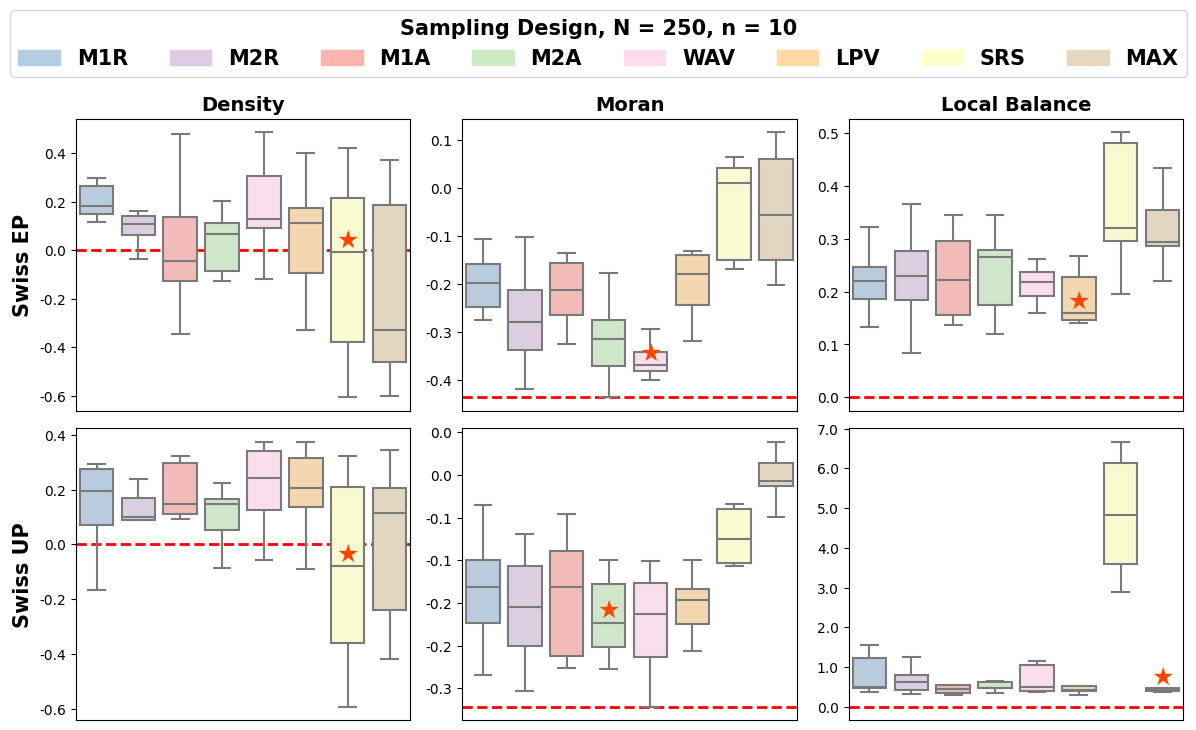

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.ticker import FuncFormatter

warnings.filterwarnings('ignore')

def find_closest_method(filtered, metric, dashed_line_value):
    """
    Find method whose median is closest to the dashed_line_value using ONLY filtered (plotted) data.
    Returns (best_method, best_median) or (None, None) if no methods have data.
    """
    methods_with_data = filtered.groupby('Method')[metric].count()
    present_methods = methods_with_data[methods_with_data > 0].index
    if len(present_methods) == 0:
        return None, None
    medians = filtered.groupby('Method')[metric].median()
    closest_method = (medians - dashed_line_value).abs().idxmin()
    return closest_method, medians[closest_method]

# Folder and file info
method_order = ["M1R", "M2R", "M1A", "M2A", "WAV", "LPV", "SRS", "MAX"]
results_folder = 'data_samples/results'
result_files = [
    f"results_swiss_eq_n={n}.csv",
    f"results_swiss_uneq_n={n}.csv",
]
pretty_names = {
    f"swiss_eq_n={n}": "Swiss EP",
    f"swiss_uneq_n={n}": "Swiss UP",
}

pop_names = [s.replace("results_", "").replace(".csv", "") for s in result_files]

# Read results into a dict
results_dict = {
    name: pd.read_csv(os.path.join(results_folder, fname))
    for name, fname in zip(pop_names, result_files)
}
method_name_mapping = {
    "K-Means (11_random)":   "M1R",
    "K-Means (22_random)":   "M2R",
    "K-Means (11_lexico)":   "M1A",
    "K-Means (22_lexico)":   "M2A",
    "Wave": "WAV",
    "Local Pivotal": "LPV",
    "Random": "SRS",
    "UPmaxentropy": "MAX"
}
for df in results_dict.values():
    df["Method"] = df["Method"].map(method_name_mapping)
for df in results_dict.values():
    if "Method Pretty" in df.columns:
        df.drop(columns=["Method Pretty"], inplace=True)
all_methods = pd.concat(list(results_dict.values()))["Method"].unique()
method_palette = dict(zip(all_methods, sns.color_palette("Pastel1", n_colors=len(all_methods))))
columns = [c for c in results_dict[pop_names[0]].columns if c != "Method"]

n_rows = len(pop_names)
n_cols = len(columns)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), sharey=False)

for row_idx, pop in enumerate(pop_names):
    df_pop = results_dict[pop]
    for col_idx, metric in enumerate(columns):
        ax = axes[row_idx, col_idx]

        # Optional: Filtering (uncomment and tune if you use)
        # filtered = df_pop[df_pop[metric] < 2]
        filtered = df_pop.copy()

        # Dashed line logic
        if metric in ['Density', 'Local Balance']:
            dashed_line_value = 0
        else:
            dashed_line_value = filtered['Moran'].min()
        ax.axhline(y=dashed_line_value, color='red', linestyle='--', linewidth=2)

        # Plot boxplot
        sns.boxplot(
            x="Method",
            y=metric,
            data=filtered,
            hue="Method",
            palette=method_palette,
            ax=ax,
            order=method_order,
            showfliers=False,
            linewidth=1.5
        )
        legend = ax.get_legend()
        if legend: legend.remove()
        if row_idx == 0:
            ax.set_title(f"{metric}", fontsize=14, weight='bold')
        else:
            ax.set_title("")
        if col_idx == 0:
            ax.set_ylabel(pretty_names.get(pop, pop), weight='bold', fontsize=15)
        else:
            ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_xticklabels([])
        ax.tick_params(axis='x', length=0)
        ax.tick_params(axis='y', labelsize=10)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.1f}"))  # 1 decimal

        # --------- Robust star annotation logic ---------
        best_method, best_median = find_closest_method(filtered, metric, dashed_line_value)
        if best_method is not None and best_method in method_order:
            x_pos = method_order.index(best_method)
            method_data = filtered[filtered["Method"] == best_method][metric].dropna()
            if len(method_data) > 0:
                box_max = method_data.max()
                ylim = ax.get_ylim()
                y_offset = 0.07 * (ylim[1] - ylim[0])
                star_y = box_max + y_offset
                star_y = best_median
                ax.annotate(
                    "★", (x_pos, star_y),
                    ha="center", va="bottom",
                    fontsize=18, color="orangered", fontweight="bold"
                )
        # If no suitable box for star, silently skip

# ----------- SHARED LEGEND BLOCK -----------
fig_legend, ax_legend = plt.subplots()
df_concat = pd.concat(list(results_dict.values()), ignore_index=True)

sns.boxplot(
    x="Method",
    y=columns[0],
    data=df_concat,
    palette=method_palette,
    ax=ax_legend,
    showfliers=False
)
handles, labels = ax_legend.get_legend_handles_labels()
if all([h is None for h in handles]) or not handles:
    labels = [t.get_text() for t in ax_legend.get_xticklabels()]
    from matplotlib.patches import Patch
    handles = [Patch(color=method_palette[l]) for l in labels]
label_to_handle = dict(zip(labels, handles))
final_labels = [m for m in method_order if m in label_to_handle]
final_handles = [label_to_handle[m] for m in final_labels]
plt.close(fig_legend)
leg = fig.legend(
    final_handles, final_labels,
    loc='upper center',
    ncol=len(final_labels),
    title=f"Sampling Design, N = {N}, n = {n}",
    fontsize=15,
    title_fontsize=15
)
for text in leg.get_texts():
    text.set_fontweight('bold')
leg.get_title().set_fontweight('bold')

fig.tight_layout(rect=[0, 0.08, 1, 1])
fig.subplots_adjust(top=0.85)
plt.show()